In [108]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from PIL import Image
from sklearn.cluster import KMeans
from skimage.filters import sobel
import skimage
import warnings
warnings.filterwarnings("ignore")

In [127]:
filename = "test.png"
img = load_img("./inputs/"+filename)

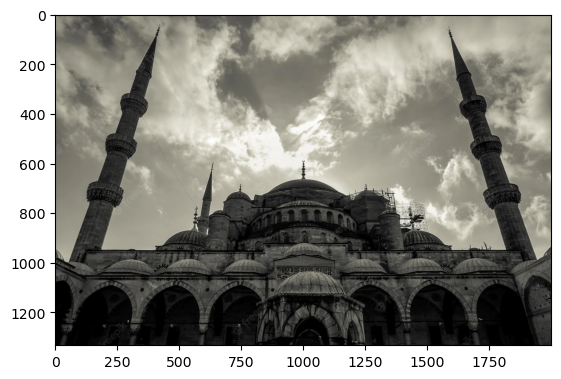

In [128]:
plt.imshow(img)

In [129]:
# Making the gray scale of the image
gray = rgb2gray(img)

In [130]:
# What if we tune the above function more??
arr=gray.flatten()
gray_segmented_2=arr.reshape(gray.shape[0],gray.shape[1])

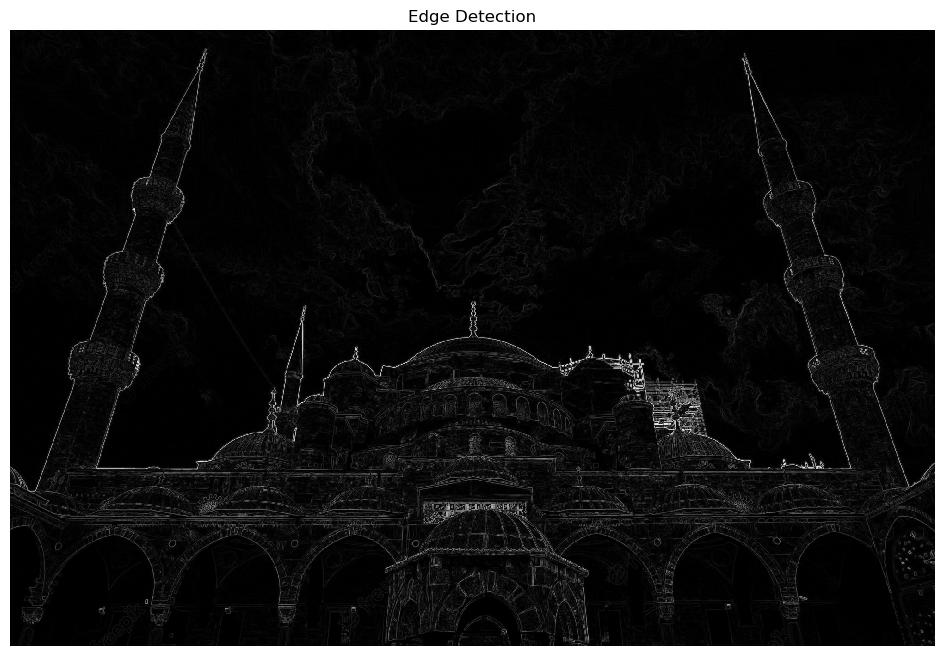

In [131]:
imm=img[:,:,0]
elevation_map = sobel(imm)

fig, ax = plt.subplots(figsize=(18,8))
ax.imshow(elevation_map, cmap='gray', interpolation='nearest')
ax.axis('off')
ax.set_title('Edge Detection')
plt.show()

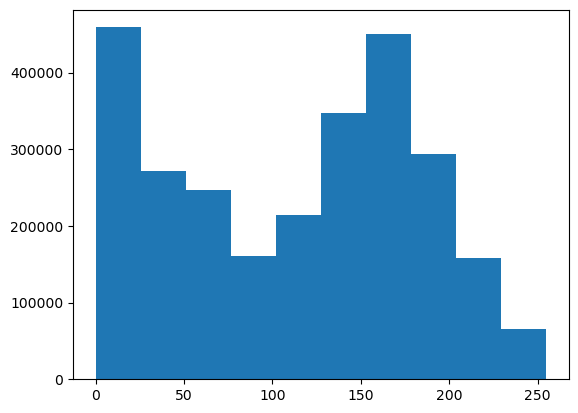

In [132]:
plt.hist(imm.flatten())
plt.show()

In [133]:
from flask import Flask, flash, request, redirect, url_for, render_template
import urllib.request
import os
from werkzeug.utils import secure_filename
import argparse
import matplotlib.pyplot as plt
from colorizers import *
from colorizers.model import generator
import warnings
from PIL import Image
import numpy as np
from skimage import color
import torch
import torch.nn.functional as F
from IPython import embed

from skimage import img_as_float
from skimage import exposure
from skimage import io # To preprocess the images
from skimage.transform import rescale

In [134]:
def load_img(img_path):
    out_np = np.asarray(Image.open(img_path))
    if(out_np.ndim == 2):
        out_np = np.tile(out_np[:, :, None], 3)
    return out_np


def resize_img(img, HW=(256, 256), resample=3):
    return np.asarray(Image.fromarray(img).resize((HW[1], HW[0]), resample=resample))


def preprocess_img(img_rgb_orig, HW=(256, 256), resample=3):
    # return original size L and resized L as torch Tensors
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)

    img_lab_orig = color.rgb2lab(img_rgb_orig)
    img_lab_rs = color.rgb2lab(img_rgb_rs)

    img_l_orig = img_lab_orig[:, :, 0]
    img_l_rs = img_lab_rs[:, :, 0]

    tens_orig_l = torch.Tensor(img_l_orig)[None, None, :, :]
    tens_rs_l = torch.Tensor(img_l_rs)[None, None, :, :]

    return (tens_orig_l, tens_rs_l)


def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
    # tens_orig_l 	1 x 1 x H_orig x W_orig
    # out_ab 		1 x 2 x H x W

    HW_orig = tens_orig_l.shape[2:]
    HW = out_ab.shape[2:]

    # call resize function if needed
    if(HW_orig[0] != HW[0] or HW_orig[1] != HW[1]):
        out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
    else:
        out_ab_orig = out_ab

    out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
    return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0, ...].transpose((1, 2, 0)))


In [135]:
# load colorizers
model1 = eccv16(pretrained=True).eval()
model2 = siggraph17(pretrained=True).eval()
colorizer_temp=generator(pretrained=False).eval()

In [136]:
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))

img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
model1_img = postprocess_tens(tens_l_orig, model1(tens_l_rs).cpu())
model2_img = postprocess_tens(tens_l_orig, model2(tens_l_rs).cpu())

temp=postprocess_tens(tens_l_orig, colorizer_temp(tens_l_rs).cpu())


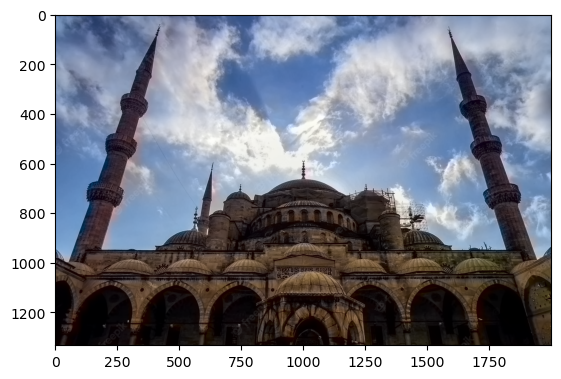

In [138]:
plt.imshow(model1_img)

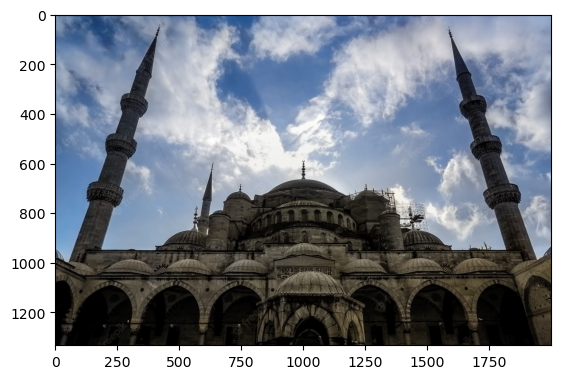

In [139]:
plt.imshow(model2_img)

In [140]:
def plot_img_and_hist(image, axes, bins=256):
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()
    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step',color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific',scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])
    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])
    return ax_img, ax_hist, ax_cdf,image
# Load a normal image

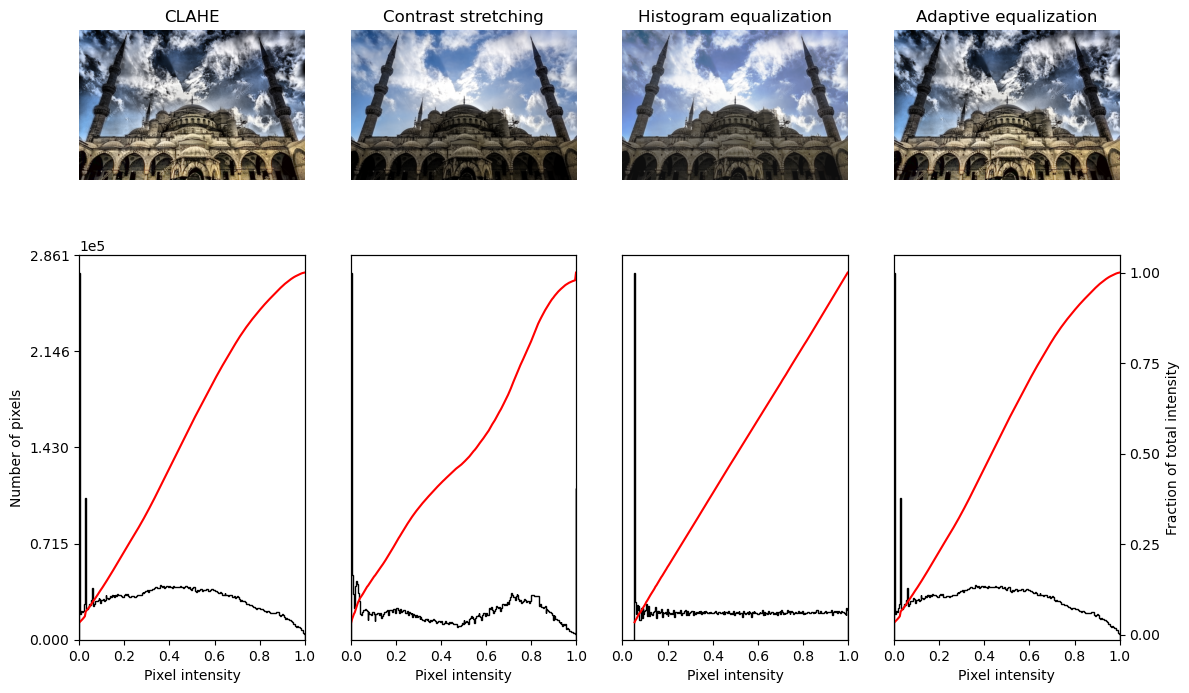

In [144]:
# Contrast stretching
p2, p98 = np.percentile(model2_img, (2, 98))
img_rescale = exposure.rescale_intensity(model2_img, in_range=(p2, p98))
# Equalization
img_eq = exposure.equalize_hist(model2_img)
# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(model2_img, clip_limit=0.03)
# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0, 0],
                                 sharey=axes[0, 0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)
ax_img, ax_hist, ax_cdf,img = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('CLAHE')
y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))
ax_img, ax_hist, ax_cdf,img = plot_img_and_hist(img_rescale, axes[:,
                                                              1])
ax_img.set_title('Contrast stretching')
ax_img, ax_hist, ax_cdf,img = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')
ax_img, ax_hist, ax_cdf,img= plot_img_and_hist(img_adapteq, axes[:,
                                                              3])
ax_img.set_title('Adaptive equalization')
ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))
# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()


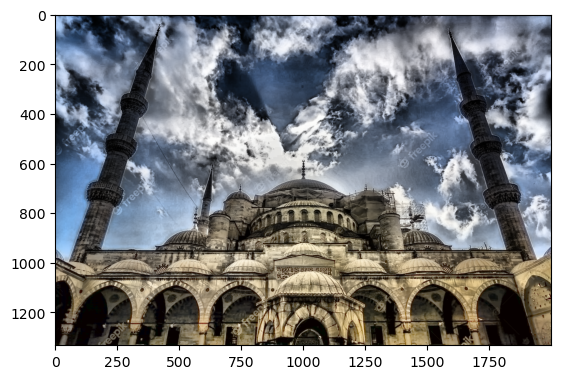

In [145]:
plt.imshow(img_adapteq)

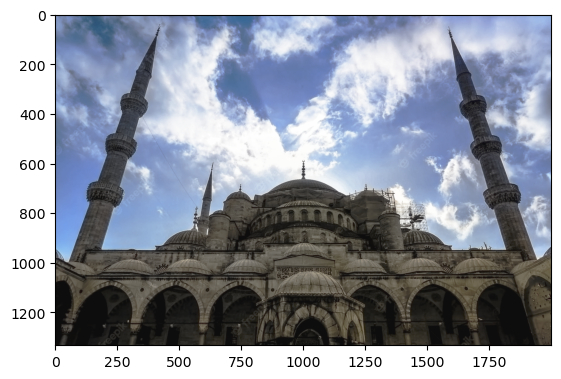

In [146]:
plt.imshow(img_eq)